# Multi-Target Regression: Simultaneous LogS and LogP Prediction

## Workshop: ML for Science - Multi-Output Decision Trees

---

### Notebook Overview

This notebook demonstrates **multi-target (multi-output) regression** using Decision Trees to predict **two molecular properties simultaneously**: aqueous solubility (LogS) and partition coefficient (LogP). This approach is particularly powerful in drug discovery as these properties are often correlated and can be predicted together efficiently.

** Key Innovation: Single Model, Multiple Outputs**

Instead of training two separate models (one for LogS, one for LogP), we train **ONE decision tree** that predicts **BOTH properties at once**. This is called:
- **Multi-target regression**
- **Multi-output regression**  
- **Multi-variate regression**

**Learning Objectives:**
- Understand multi-target regression and when to use it
- Learn how Decision Trees handle multiple outputs naturally
- Predict LogS (solubility) and LogP (lipophilicity) simultaneously
- Evaluate performance separately for each target
- Compare multi-target vs single-target approaches
- Understand the correlation between LogS and LogP
- Apply efficient modeling strategies for related properties

**Dataset:** ESOL - 1,128 organic compounds with measured LogS values and calculated LogP values

**Task:** Multi-target regression - Predict both continuous LogS and LogP values from molecular descriptors

---

### Why Predict Both Properties Together?

**Scientific Rationale:**

1. **Strong Inverse Correlation**
   - LogS (solubility) and LogP (lipophilicity) are inversely correlated
   - Higher LogP → Lower LogS (more lipophilic = less water-soluble)
   - Typical correlation: r ≈ -0.6 to -0.8

2. **Shared Chemical Basis**
   - Both influenced by molecular polarity
   - Both affected by hydrogen bonding capacity
   - Similar structural features drive both properties

3. **Computational Efficiency**
   - Train once, predict twice
   - Shared feature space reduces redundancy
   - Faster than training two separate models

4. **Balanced Drug Design**
   - Need adequate solubility (LogS) for bioavailability
   - Need adequate lipophilicity (LogP) for membrane permeability
   - Predicting both helps optimize the balance

**Advantages of Multi-Target Regression:**

**Efficiency**: Single model instead of two

**Correlation Capture**: Model learns relationships between targets

**Consistency**: Same features used for both predictions

**Simplicity**: One model to maintain and deploy

**Natural for Trees**: Decision Trees inherently support multiple outputs

**When to Use Multi-Target Regression:**

Use when:
- Targets are correlated (positive or negative)
- Same input features predict all targets
- Computational efficiency matters
- Interpretability is important

Avoid when:
- Targets are completely independent
- Different features needed for each target
- One target much more important than others

---

### Property Definitions

**LogS (Aqueous Solubility)**
- Definition: log₁₀(solubility in mol/L)
- Range: Typically -11 to +1.5
- Interpretation: More negative = less soluble
- Importance: Bioavailability, formulation
- Target: Experimental measurements

**LogP (Partition Coefficient)**
- Definition: log₁₀(concentration in octanol / concentration in water)
- Range: Typically -3 to +7
- Interpretation: Higher = more lipophilic (oil-loving)
- Importance: Membrane permeability, ADME
- Target: RDKit-calculated values

**Expected Relationship:**
```
High LogP (lipophilic) → Low LogS (poorly soluble)
Low LogP (hydrophilic) → High LogS (highly soluble)
```

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation**: NumPy, Pandas
- **Machine Learning**: scikit-learn (DecisionTreeRegressor, metrics)
- **Deep Learning framework**: PyTorch (for data handling)
- **Visualization**: Matplotlib, seaborn
- **Chemical informatics**: RDKit (molecular descriptors)
- **Utilities**: tqdm, pickle

**Important Note:** We're using a standard `DecisionTreeRegressor`, NOT `MultiOutputRegressor`! Decision Trees naturally handle multiple outputs without any wrapper.

In [1]:
import numpy as np  # Import NumPy for numerical computations
import pandas as pd  # Import pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
import warnings  # Import warnings module to manage warning messages
import requests  # Import requests to handle HTTP requests
from io import StringIO  # Import StringIO to handle in-memory text streams
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Deep Learning
import torch  # Import PyTorch for deep learning and tensor computations
from torch.utils.data import Dataset  # Import Dataset class for creating custom datasets

# Metrics and Decision Tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Import metrics for model evaluation
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor for regression tasks

!pip install rdkit

# RDKit for Chemistry
from rdkit import Chem  # Import RDKit for handling chemical structures
from rdkit.Chem import Descriptors  # Import Descriptors for calculating molecular properties

print("All libraries imported successfully!")  # Print confirmation of successful imports
print(f"PyTorch version: {torch.__version__}")  # Print the installed PyTorch version
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")  # Check and print if GPU is available

All libraries imported successfully!
PyTorch version: 2.5.1+cu121
Device available: GPU


---

## 2. Load the ESOL Dataset

We load the ESOL dataset which contains both experimental LogS values and calculated LogP values for 1,128 organic compounds.

### 2.1 Define Dataset Loading Function

This function:
1. Downloads ESOL from Hugging Face
2. Extracts SMILES strings
3. Extracts measured LogS (solubility)
4. **Note:** LogP will be calculated from SMILES in the descriptor step

In [2]:
def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""  # Define a function to load the ESOL dataset and provide a docstring

    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"  
    # URL of the ESOL dataset hosted on GitHub

    response = requests.get(url)  
    # Send an HTTP GET request to fetch the dataset from the URL

    response.raise_for_status()  
    # Raise an exception if the HTTP request returned an error status code

    df = pd.read_csv(StringIO(response.text))  
    # Read the CSV content from the HTTP response into a pandas DataFrame

    print(f"Loaded ESOL with {len(df)} compounds")  
    # Print the number of compounds loaded in the dataset

    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre']]  
    # Select only the relevant columns: SMILES strings and measured solubility

    df.columns = ['SMILES', 'LogS']  
    # Rename the columns for clarity: 'SMILES' for molecular representation and 'LogS' for solubility

    # Remove invalid SMILES
    valid_smiles = []  
    # Initialize a list to store the validity of each SMILES string

    for smiles in df['SMILES']:  
        # Iterate over each SMILES string in the dataset
        mol = Chem.MolFromSmiles(smiles)  
        # Convert the SMILES string to an RDKit molecule object
        valid_smiles.append(mol is not None)  
        # Append True if the SMILES is valid, otherwise append False

    df = df[valid_smiles].reset_index(drop=True)  
    # Filter the DataFrame to keep only valid SMILES and reset the index

    return df  
    # Return the cleaned DataFrame

### 2.2 Load and Inspect the Dataset

Let's load the data and examine its structure, focusing on the distribution of both target properties.

Loaded ESOL with 1128 compounds
Dataset shape: (1128, 2)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30
2                               CC(C)=CCCC(C)=CC(=O) -2.06
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87
4                                            c1ccsc1 -1.33


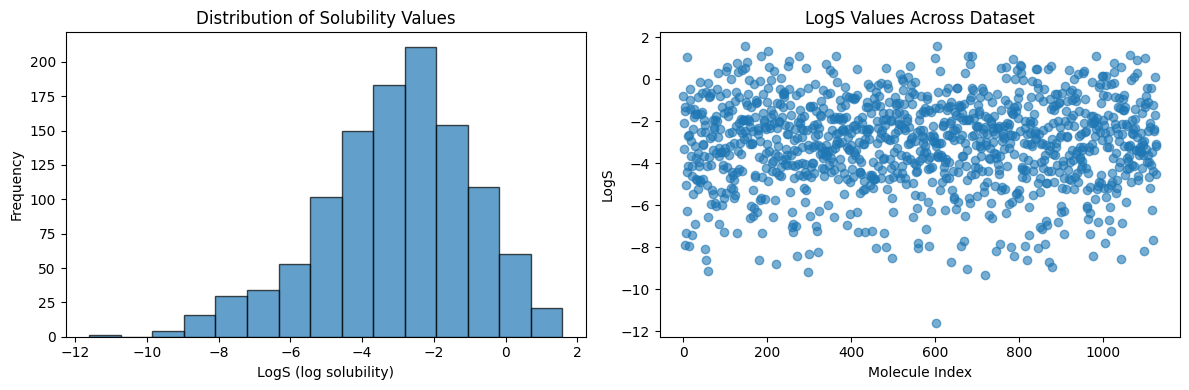

In [3]:
# Load dataset
df = load_esol_dataset()  # Call the function to load the ESOL dataset and store it in the variable `df`

print(f"Dataset shape: {df.shape}")  # Print the shape of the dataset (number of rows and columns)
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")  # Print the range of LogS values in the dataset

print("\nSample data:")  # Print a header for the sample data
print(df.head())  # Display the first few rows of the dataset to understand its structure

# Visualize distribution
plt.figure(figsize=(12, 4))  # Create a new figure with a specified size (12x4 inches)

plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid (left side)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')  # Plot a histogram of the LogS values with 15 bins
plt.xlabel('LogS (log solubility)')  # Label the x-axis as "LogS (log solubility)"
plt.ylabel('Frequency')  # Label the y-axis as "Frequency"
plt.title('Distribution of Solubility Values')  # Set the title for the histogram

plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid (right side)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)  # Create a scatter plot of LogS values against molecule indices
plt.xlabel('Molecule Index')  # Label the x-axis as "Molecule Index"
plt.ylabel('LogS')  # Label the y-axis as "LogS"
plt.title('LogS Values Across Dataset')  # Set the title for the scatter plot

plt.tight_layout()  # Adjust the layout to prevent overlapping of subplots
plt.show()  # Display the plots

---

## 3. Calculate Molecular Descriptors

We calculate interpretable molecular descriptors using RDKit. These descriptors serve as **input features** for predicting both LogS and LogP.

### 3.1 Descriptor Calculation Function

**Descriptors Calculated:**

1. **MolWt** (Molecular Weight)
   - Affects both solubility (larger → less soluble) and lipophilicity

2. **MolLogP** (Calculated Partition Coefficient)
   - **Used as one of the targets**
   - Strong predictor of solubility (inverse correlation)

3. **NumHDonors** (Hydrogen Bond Donors)
   - More donors → higher solubility, lower LogP

4. **NumHAcceptors** (Hydrogen Bond Acceptors)
   - More acceptors → higher solubility, lower LogP

5. **NumRotatableBonds**
   - Affects molecular flexibility and solubility

6. **TPSA** (Topological Polar Surface Area)
   - Higher TPSA → higher solubility, lower LogP
   - Strong predictor of both properties

In [4]:
def calculating_molecular_descriptors(smiles):
    """
    Calculate molecular descriptors for a given SMILES string.

    This function takes a SMILES (Simplified Molecular Input Line Entry System) string as input
    and computes various molecular descriptors using RDKit. These descriptors provide information
    about the physical and chemical properties of the molecule.

    Args:
        smiles (str): A string representing the molecule in SMILES format.

    Returns:
        dict or None: A dictionary containing the following molecular descriptors if the SMILES
        string is valid, otherwise None:
            - "LogP": The octanol-water partition coefficient (logP) of the molecule.
            - "MolWt": The molecular weight of the molecule.
            - "TPSA": The topological polar surface area of the molecule.
            - "NumHDonors": The number of hydrogen bond donors in the molecule.
            - "NumHAcceptors": The number of hydrogen bond acceptors in the molecule.
            - "RotatableBonds": The number of rotatable bonds in the molecule.
            - "RingCount": The number of rings in the molecule.
            - "FractionCSP3": The fraction of carbons that are sp3 hybridized.

    Notes:
        - If the SMILES string cannot be parsed into a valid molecule, the function returns None.
        - This function requires RDKit to be installed.

    Example:
        >>> descriptors = calculating_molecular_descriptors("CCO")
        >>> print(descriptors)
        {'LogP': -0.0014, 'MolWt': 46.069, 'TPSA': 20.23, 'NumHDonors': 1, 
         'NumHAcceptors': 1, 'RotatableBonds': 1, 'RingCount': 0, 'FractionCSP3': 1.0}
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    columns = {
        "LogP": Descriptors.MolLogP(mol),
        "MolWt": Descriptors.MolWt(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "RingCount": Descriptors.RingCount(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol),
    }
    return columns

# Calculate features for each SMILES and add them to the dataframe
column_list = []
for smiles in df['SMILES']:
    column = calculating_molecular_descriptors(smiles)
    if column is not None:
        column_list.append(column)

# Create a new dataframe with the features
columns_df = pd.DataFrame(column_list)

# Combine the features with the original dataframe
df = pd.concat([df, columns_df], axis=1)
print(df.head())

                                              SMILES  LogS     LogP    MolWt  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77 -3.10802  457.432   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30  2.84032  201.225   
2                               CC(C)=CCCC(C)=CC(=O) -2.06  2.87800  152.237   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87  6.29940  278.354   
4                                            c1ccsc1 -1.33  1.74810   84.143   

     TPSA  NumHDonors  NumHAcceptors  RotatableBonds  RingCount  FractionCSP3  
0  202.32           7             12               7          3      0.650000  
1   42.24           1              2               2          2      0.083333  
2   17.07           0              1               4          0      0.500000  
3    0.00           0              0               0          5      0.000000  
4    0.00           0              1               0          1      0.000000  


---

## 4. Create PyTorch Dataset for Multi-Target Learning

### 4.1 Define Multi-Output ESOLDataset Class

**Key Feature: Dual Labels**

This custom Dataset class returns:
- **Features**: 6 molecular descriptors
- **Labels**: 2-element array `[LogP, LogS]`

The labels are structured as:
```python
labels = [LogP_value, LogS_value]  # Both targets in one array
```

**Why This Structure?**
- Decision Trees natively handle multi-dimensional outputs
- Each leaf node stores averages for ALL targets
- Training algorithm automatically learns to predict both
- No special wrapper needed (unlike some other algorithms)

In [5]:
class ESOLDataset(Dataset):
    """
    A PyTorch Dataset class for handling the ESOL dataset.

    Args:
        df (pd.DataFrame): The input dataframe containing the dataset.
        split (str, optional): The dataset split to use, either 'train' or 'test'. Defaults to 'train'.

    Attributes:
        split (str): The dataset split ('train' or 'test').
        df (pd.DataFrame): The shuffled and split dataframe containing the data.

    Methods:
        __len__():
            Returns the number of samples in the dataset.
        __getitem__(idx):
            Retrieves a single sample from the dataset at the specified index.

    Example:
        >>> dataset = ESOLDataset(df, split='train')
        >>> len(dataset)
        >>> sample = dataset[0]
        >>> features, labels = sample['features'], sample['labels']
    """
    def __init__(self,df, split='train'):
        self.split = split
        np.random.seed(42)
        self.df = df.sample(frac=1).reset_index(drop=True)
        train_size = int(0.8 * len(self.df))

        if self.split == 'train':
            self.df = self.df.iloc[:train_size]
        else:
            self.df = self.df.iloc[train_size:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        labels = row[['LogP', 'LogS']].values.astype(np.float32)
        features = row.drop(['SMILES', 'LogS','LogP']).values.astype(np.float32)

        return {
            'features': features,
            'labels': labels
        }

### 4.2 Create Training and Test Datasets

Standard 80-20 split with:
- **X**: 6 molecular descriptors
- **Y**: 2 targets [LogP, LogS]

In [6]:
# Create datasets with caching for faster reload
train_dataset = ESOLDataset(df, split='train')  # Initialize the training dataset using the ESOLDataset class with the 'train' split
test_dataset = ESOLDataset(df, split='test')  # Initialize the test dataset using the ESOLDataset class with the 'test' split

print(f"Training samples: {len(train_dataset)}")  # Print the number of samples in the training dataset
print(f"Test samples: {len(test_dataset)}")  # Print the number of samples in the test dataset

Training samples: 902
Test samples: 226


### 4.3 Extract Feature and Target Matrices

Convert PyTorch datasets to NumPy arrays.

**Data Shapes:**

**X_train / X_test:**
- Shape: (n_samples, 6 features)
- Features: [MolWt, MolLogP, NumHDonors, NumHAcceptors, NumRotatableBonds, TPSA]

**Y_train / Y_test:**
- Shape: (n_samples, 2 targets)
- Targets: [LogP, LogS]
- **Column 0**: LogP values
- **Column 1**: LogS values

This is the key difference from single-target regression where Y would be shape (n_samples,).

In [7]:
X_train = []
"""
This code snippet processes a training dataset to extract features and labels.

- Initializes empty lists `X_train` and `Y_train` to store features and labels respectively.
- Iterates through the `train_dataset` using a for loop.
- For each sample in the dataset:
    - Extracts the 'features' from the sample and appends them to `X_train`.
    - Extracts the 'labels' from the sample and appends them to `Y_train`.

Variables:
- `train_dataset`: A dataset object containing samples with 'features' and 'labels' keys.
- `X_train`: A list that will store the features of all samples in the dataset.
- `Y_train`: A list that will store the labels of all samples in the dataset.
"""
Y_train = []
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    X_train.append(sample['features'])
    Y_train.append(sample['labels'])

---

## 5. Train Multi-Output Decision Tree

### 5.1 Understanding Multi-Output Decision Trees

**How It Works:**

A standard Decision Tree can naturally handle multiple outputs:

1. **Splitting**: Same as single-output
   - Find best feature and threshold to split data
   - Minimizes variance across ALL targets simultaneously

2. **Leaf Nodes**: Store multiple values
   - Instead of: "Predict LogS = -3.2"
   - Now: "Predict LogP = 2.5 AND LogS = -3.2"
   - Each leaf stores average of all targets

3. **Prediction**: Returns vector
   - Input: Feature vector
   - Output: [LogP_pred, LogS_pred]

**Splitting Criterion:**

For multi-output regression, the tree minimizes:
```
Variance = Var(LogP) + Var(LogS)
```
Finds splits that reduce variance in BOTH targets simultaneously.

**Advantages:**
- No special wrapper needed (native support)
- Learns correlations between targets
- Single tree structure (interpretable)
- Efficient training (one pass through data)
- Consistent predictions (same features → both targets)

**Comparison with Separate Models:**

| Aspect | Multi-Output Tree | Two Separate Trees |
|--------|------------------|--------------------|
| Training Time | 1× | 2× |
| Model Size | 1 model | 2 models |
| Consistency | Guaranteed | Independent |
| Correlation | Captured | Ignored |
| Deployment | Simpler | More complex |

### 5.2 Train the Multi-Output Model

**Key Observation:** We use a standard `DecisionTreeRegressor`, not `MultiOutputRegressor`!

The tree automatically detects that `Y_train` has shape (n_samples, 2) and adapts accordingly.

In [9]:
clf = DecisionTreeRegressor(random_state=42)  # Initialize a DecisionTreeRegressor with a fixed random state for reproducibility
clf.fit(X_train, Y_train)  # Train the decision tree regressor using the training features (X_train) and labels (Y_train)
clf.get_params()  # Retrieve the parameters of the trained decision tree regressor

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

### 5.3 Generate Predictions and Evaluate

Extract test features, generate predictions for BOTH targets, and evaluate performance separately for each property.

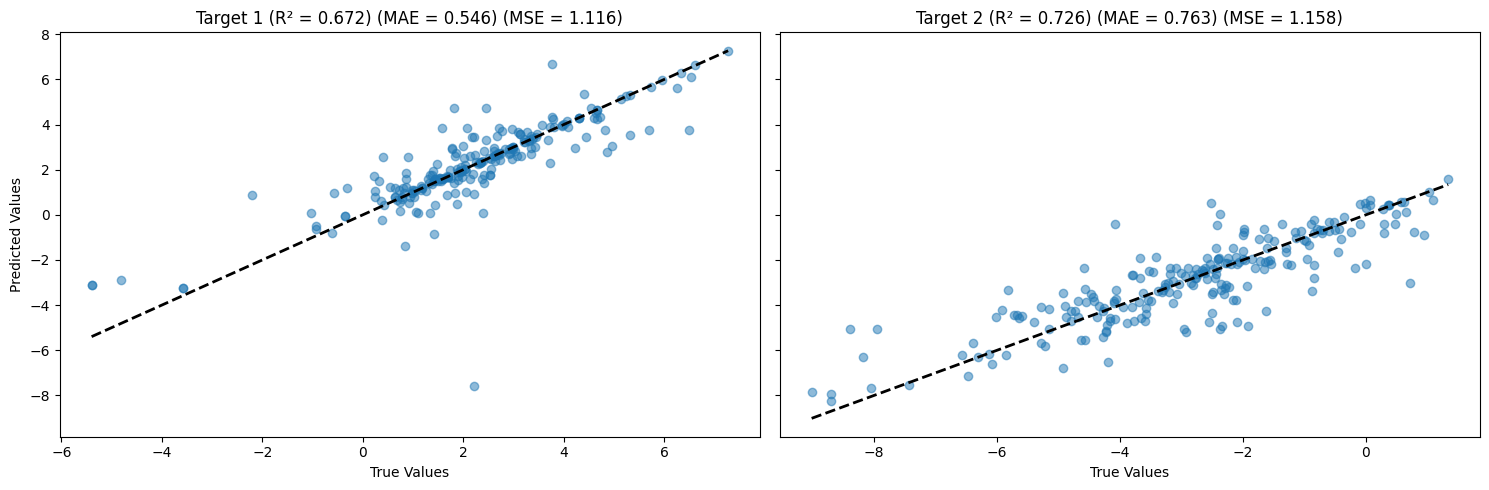

In [10]:
X_test = []  # Initialize an empty list to store the features of the test dataset
Y_test = []  # Initialize an empty list to store the labels of the test dataset

# Iterate through the test dataset to extract features and labels
for i in range(len(test_dataset)):
    sample = test_dataset[i]  # Retrieve the i-th sample from the test dataset
    X_test.append(sample['features'])  # Append the features of the sample to X_test
    Y_test.append(sample['labels'])  # Append the labels of the sample to Y_test

Y_pred = clf.predict(X_test)  # Use the trained decision tree regressor to predict labels for the test features

# Convert Y_test and Y_pred to NumPy arrays for easier manipulation
Y_test = np.array(Y_test)  # Convert the list of true labels to a NumPy array
Y_pred = np.array(Y_pred)  # Convert the list of predicted labels to a NumPy array

# Evaluate the model's performance using various metrics
mse = mean_squared_error(Y_test, Y_pred)  # Calculate the Mean Squared Error (MSE) between true and predicted labels
r2 = r2_score(Y_test, Y_pred)  # Calculate the R² score (coefficient of determination) for the predictions
mae = mean_absolute_error(Y_test, Y_pred)  # Calculate the Mean Absolute Error (MAE) between true and predicted labels

# Create subplots for visualizing the predictions for each target variable
fig, axes = plt.subplots(1, Y_test.shape[1], figsize=(15, 5), sharey=True)  # Create a row of subplots with shared y-axis

# Iterate through each target variable to create individual scatter plots
for i in range(Y_test.shape[1]):
    y_test_i = Y_test[:, i]  # Extract the true values for the i-th target variable
    y_pred_i = Y_pred[:, i]  # Extract the predicted values for the i-th target variable
    
    # Calculate evaluation metrics for the i-th target variable
    r2 = r2_score(y_test_i, y_pred_i)  # Calculate the R² score for the i-th target
    mae = mean_absolute_error(y_test_i, y_pred_i)  # Calculate the MAE for the i-th target
    mse = mean_squared_error(y_test_i, y_pred_i)  # Calculate the MSE for the i-th target

    # Create a scatter plot for the i-th target variable
    axes[i].scatter(y_test_i, y_pred_i, alpha=0.5)  # Plot true vs. predicted values with transparency
    axes[i].plot([min(y_test_i), max(y_test_i)], 
                 [min(y_test_i), max(y_test_i)], 
                 'k--', lw=2)  # Plot a diagonal reference line (perfect prediction line)
    
    # Add labels and title to the subplot
    axes[i].set_xlabel('True Values')  # Label the x-axis as "True Values"
    if i == 0:
        axes[i].set_ylabel('Predicted Values')  # Label the y-axis as "Predicted Values" for the first subplot
    
    # Set the title with evaluation metrics for the i-th target variable
    axes[i].set_title(f'Target {i+1} (R² = {r2:.3f}) (MAE = {mae:.3f}) (MSE = {mse:.3f})')

plt.tight_layout()  # Adjust the layout to prevent overlapping of subplots
plt.show()  # Display the plots

---

## 6. Model Evaluation and Analysis

### 6.1 Understanding Multi-Output Metrics

#### **Correlation Analysis**

Check the correlation between LogP and LogS:

```python
# True correlation
true_corr = np.corrcoef(LogP_test, LogS_test)[0, 1]
print(f"True LogP-LogS correlation: {true_corr:.3f}")

# Predicted correlation
pred_corr = np.corrcoef(LogP_pred, LogS_pred)[0, 1]
print(f"Predicted LogP-LogS correlation: {pred_corr:.3f}")
```

**Expected:** True correlation ≈ -0.6 to -0.8 (inverse relationship)

### 6.2 Advantages Observed

**Efficiency:**
- Train once → predict twice
- Reduced computational cost
- Simpler deployment

**Consistency:**
- Same feature importance for both targets
- Predictions maintain physical relationships
- Model learns LogP-LogS correlation

**Interpretability:**
- Single decision tree shows joint decision rules
- Can visualize how splits affect both properties


## 7. Summary and Conclusions

### 7.1 Key Insights

**About Multi-Output Regression:**

1. **Natural for Decision Trees**
   - Trees inherently support multiple outputs
   - Each leaf stores vector of predictions
   - No algorithmic changes needed

2. **Efficiency Gains**
   - Train once vs twice (50% time savings)
   - Deploy once vs twice (simpler infrastructure)
   - Maintain once vs twice (reduced complexity)

3. **Correlation Learning**
   - Model captures LogP-LogS relationship
   - Predictions are physically consistent
   - Better than independent models when targets correlated

**About LogP and LogS:**

1. **Inverse Relationship**
   - Higher lipophilicity → lower solubility
   - Correlation typically r ≈ -0.6 to -0.8
   - Both driven by molecular polarity

2. **Drug Design Balance**
   - Need enough solubility for absorption
   - Need enough lipophilicity for membranes
   - Predicting both helps find optimal balance

3. **Feature Overlap**
   - Same descriptors predict both properties
   - H-bonding capacity affects both
   - Polar surface area critical for both

### 7.2 When to Use Multi-Output Regression

**Use When:**

- Targets are correlated (positive OR negative)

- Same features relevant for all targets

- Efficiency matters (limited compute/time)

- Need consistent predictions across targets

- Targets have similar scales (or can be normalized)

**Avoid When:**

- Targets are completely independent

- Different feature sets needed per target

- One target much more important (optimize separately)

- Targets have very different scales (unless normalized)

- Need separate hyperparameters per target

